In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import scipy.optimize
import scipy.stats
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
from sklearn import tree
from sklearn.model_selection import train_test_split
#import algopy
#from algopy import UTPM, exp
import copy
import calendar
#import seaborn as sns

import plotting
import dataset_fctns
import modelling_fctns
import seaborn as sns
#from dwd_phenpy import Phenology_set

#import openeo
#import ee
## Trigger the authentication flow.
#ee.Authenticate()#(auth_mode='localhost')
# Initialize the library.
#ee.Initialize(project='ee-martinparker637')

In [ ]:
ds = xr.open_dataset('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\Saved_files\\ERA5\\ERA5_land_2011.nc')
for year in range(2011, 2025):
    ds = xr.concat([ds, xr.open_dataset(f'C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\Saved_files\\ERA5\\ERA5_land_{year}.nc')], dim='valid_time')
ds = ds.rename({'valid_time':'time'})
ds = ds.sortby('time')

In [24]:
d2m = ds['d2m'].resample(time="1D").mean()
t2m = ds['t2m'].resample(time="1D").mean()
ds_for_solrad = ds.where((ds['time.hour'] > 5)*(ds['time.hour'] < 19), drop=True)
ssrd = ds_for_solrad['ssrd'].resample(time="1D").mean()
tp = ds['tp'].resample(time="1D").sum()
ds_for_driver = xr.merge([d2m, t2m, ssrd, tp])
#ds_for_driver.to_netcdf('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\Saved_files\\ERA5\\ERA5_land_2018_2024.nc')
#ds_for_driver = xr.open_dataset('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\Saved_files\\ERA5\\ERA5_land_2018_2024.nc')
ds_for_driver['t2m'] += -273.15
ds_for_driver.to_netcdf('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\Saved_files\\ERA5\\ERA5_land_2011_2024.nc')
#ds.to_netcdf('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\Saved_files\\ERA5\\ERA5_land_2018_2024.nc')
#ds3 = xr.open_dataset('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\Saved_files\\ERA5\\ERA5_land_2018_2024.nc')

In [34]:
ds2 = xr.open_dataset('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\Saved_files\\ERA5\\ERA5_land_2011_2024.nc')
ds2.close()
ds2 = ds2.rename({'latitude':'lat', 'longitude':'lon'})
ds2.to_netcdf('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\Saved_files\\ERA5\\ERA5_land2_2011_2024.nc')

In [2]:
class Phenology_set:

    phase_names = pd.read_csv("https://opendata.dwd.de/climate_environment/CDC/help/PH_Beschreibung_Phase.txt", encoding = "latin1", engine='python', sep = r';\s+|;\t+|;\s+\t+|;\t+\s+|;|\s+;|\t+;|\s+\t+;|\t+\s+;')
    station_data = pd.read_csv("https://opendata.dwd.de/climate_environment/CDC/help/PH_Beschreibung_Phaenologie_Stationen_Jahresmelder.txt",sep = ";\s+|;\t+|;\s+\t+|;\t+\s+|;|\s+;|\t+;|\s+\t+;|\t+\s+;", encoding='cp1252', on_bad_lines='skip')
    
    def __init__(self, address, raw = False):
        if raw:
            self.phen_data = pd.read_csv(address, encoding = "latin1", engine='python', sep = r';\s+|;\t+|;\s+\t+|;\t+\s+|;|\s+;|\t+;|\s+\t+;|\t+\s+;')
        else:
            self.phen_data = pd.read_csv(address)
        ## CONVERT DATE TO DATETIME ##
        self.phen_data['Eintrittsdatum'] = pd.to_datetime(self.phen_data['Eintrittsdatum'], format = '%Y%m%d')
        self.phen_data = self.phen_data.drop(self.phen_data[self.phen_data['Qualitaetsniveau'] != 10].index)
        self.phase_list = [] #list of phases to consider
        self.add_locations()
        #print(self.phen_data['Qualitaetsniveau'].values)
        self.T_mean = ''
        self.GDD_driver_data = ''
        self.ordered = False
        self.first_input_array = True

    ### Functions for sorting out dataset ###
    def drop_columns(self, drop_list):
        for drop_name in drop_list:
            try:
                self.phen_data = self.phen_data.drop(drop_name, axis = 1)
            except:
                print(f'Column {drop_name} not found')
                continue
    
    def phase_order_name(self, stage_order): #[10, 12, 67, 65, 5, 6, 19, 20, 21, 24, ]
        self.phen_data['Order of phase'] = np.nan
        self.phen_data['Name of phase'] = ''
        for i, phaseid in enumerate(stage_order):
            if len(self.phase_names['Phase_englisch'][self.phase_names['Phase_ID'] == str(phaseid)]) != 0:
                #print(i, phaseid)
                self.phen_data.loc[self.phen_data['Phase_id'] == phaseid, 'Order of phase'] = i
                self.phen_data.loc[self.phen_data['Phase_id'] == phaseid, 'Name of phase'] = dataset_fctns.get_phase_name(phaseid, self.phase_names)
        self.order_phen_dataset()

    def order_phen_dataset(self):
        ## SORT BY TIME ##
        if not(np.isin('Order of phase', self.phen_data.columns)):
            print('Get phase order and names first')
        else:
            self.phen_data.sort_values(by = ['Stations_id', 'Referenzjahr', 'Eintrittsdatum', 'Order of phase'])
            self.ordered = True
    
    def get_time_to_next_stage(self):
        #Note phen_data must be time and station ordered. Only plots time to next stage - naive as doesn't consider missing phases.
        if self.ordered:
            ## CALCULATE TIME TO NEXT STAGE ##
            self.phen_data['Time to next stage'] = self.phen_data['Eintrittsdatum'].shift(-1) - self.phen_data['Eintrittsdatum']
            self.phen_data['Next stage name'] = self.phen_data['Name of phase'].shift(-1)
            ## EXCLUDE CHANGES IN STATION ##
            self.phen_data.loc[self.phen_data['Stations_id'] != self.phen_data['Stations_id'].shift(-1), 'Time to next stage'] = np.nan
            self.phen_data.loc[self.phen_data['Stations_id'] != self.phen_data['Stations_id'].shift(-1), 'Next stage name'] = np.nan
        else:
            print('Order dataset so I can get time to next stage')

    def add_locations(self):
        self.phen_data = dataset_fctns.get_station_locations(self.phen_data, self.station_data)
        #LAT, LON = dataset_fctns.get_station_locations(self.phen_data, self.station_data)
        #self.phen_data['lat'] = LAT
        #self.phen_data['lon'] = LON
        #self.phen_data['lat'] = self.phen_data['lat'].map(lambda x: x[0] if isinstance(x, np.float64) == False else x)
        #self.phen_data['lon'] = self.phen_data['lon'].map(lambda x: x[0] if isinstance(x, np.float64) == False else x)
    ### Functions for applying GDD model ###
    def get_mean_T(self, T_address):
        self.T_mean = xr.open_dataset(T_address)

    def index_time_from_emergence_day(self):
        i_day = self.GDD_driver_data['emergence_dates'].values.copy()
        i_daysofyear = np.array([i_day + np.timedelta64(12, 'h') + np.timedelta64(day_of_year, 'D') for day_of_year in range(366)])
        time_indexer = xr.DataArray(i_daysofyear, dims=[ "time", 'modelpoint'])
        self.GDD_driver_data = self.GDD_driver_data.sel(time=time_indexer, method='nearest')

    def align_emergence_obs_with_driver_data(self):
        ## Make sure we are comparing to observations where we have the driver data;
        #1. Align the times - need to check as it might run for some days then go off the end.
        #self.just_emergence = self.just_emergence.where(self.just_emergence['Referenzjahr'] <= 2024)
        ## Make sure all elements are in the driver data
        self.just_emergence = self.just_emergence.loc[np.isin(self.just_emergence['Eintrittsdatum'] + np.timedelta64(12, 'h'), self.GDD_driver_data['time'])]
        self.just_emergence = self.just_emergence.loc[np.isin(self.just_emergence['Stations_id'], self.GDD_driver_data['Stations_id'])]
        self.just_emergence = self.just_emergence.dropna()
    
    def get_unique_xy_station(self, x_coords, y_coords, station_ids):
        unique_values = np.unique(np.stack([x_coords, y_coords, station_ids]), axis = 1)
        return unique_values[0, :], unique_values[1, :], unique_values[2, :]

    def make_input_array(self, epsg_num = 3035, latlon_proj = False):
        self.latlon_proj = latlon_proj
        ## Puts pandas phenological frame into driver xarray and aligns the two
        #self.just_emergence = self.phen_data.where(self.phen_data['Name of phase'] == 'beginning of emergence').dropna()
        ## For now just do data after 2005 to save time
        if self.first_input_array:
            self.obs_for_GDD = self.phen_data.where(self.phen_data['Eintrittsdatum'] >= np.datetime64('2001-01-01')).dropna()
            x_coords = self.obs_for_GDD['lon'].values
            y_coords = self.obs_for_GDD['lat'].values
            station_ids = np.int64(self.obs_for_GDD['Stations_id'].values)
            x_unique, y_unique, stations = self.get_unique_xy_station(x_coords, y_coords, station_ids)
            #Makes an array to put into GDD model
            print('project to new coords')
            self.stations = stations
            if not(latlon_proj):
                x_epsg, y_epsg = dataset_fctns.latlon_to_projection(x_unique, y_unique, epsg_num = epsg_num)
                self.x_driver_proj = x_epsg
                self.y__driver_proj = y_epsg
            else:
                self.x_driver_proj = x_unique
                self.y__driver_proj = y_unique
            print('interpolate driver to station locations')
            # Working in xarray (not pandas) after this point:
            #print('Latlonproj:', not(latlon_proj))
            self.GDD_driver_data = dataset_fctns.interpolate_xy(self.x_driver_proj, self.y__driver_proj, self.T_mean, xy=not(latlon_proj))
            self.GDD_driver_data = self.GDD_driver_data.assign_coords(Stations_id=("modelpoint", self.stations))
            if not(latlon_proj):
                self.GDD_driver_data = self.GDD_driver_data.drop_dims('bnds')
            self.GDD_driver_data = self.GDD_driver_data.set_xindex(['Stations_id'])
            self.first_input_array = False
        else: 
            new_GDD_driver_data = dataset_fctns.interpolate_xy(self.x_driver_proj, self.y__driver_proj, self.T_mean, xy=not(latlon_proj))
            new_GDD_driver_data = new_GDD_driver_data.assign_coords(Stations_id=("modelpoint", self.stations))
            if not(latlon_proj):
                new_GDD_driver_data = self.GDD_driver_data.drop_dims('bnds')
            new_GDD_driver_data = new_GDD_driver_data.set_xindex(['Stations_id'])
            self.GDD_driver_data = xr.concat([self.GDD_driver_data, new_GDD_driver_data], dim='time')
            self.GDD_driver_data = self.GDD_driver_data.sortby('time')

    def dev_under_response(self, response, driver_variable, maturity_t_dev):
        # Response is the rate response to driver values. Driver values are the input to this response. Maturity_t_dev is the t_dev value where we should stop running.
        self.obs_for_GDD = self.obs_for_GDD.where(self.obs_for_GDD['Referenzjahr'] <= 2023)
        ## Make the indexer to extract things at the right time.
        #self.align_emergence_obs_with_driver_data()
        self.obs_for_GDD = dataset_fctns.add_SOS_to_df(self.obs_for_GDD)
        self.obs_for_GDD['WC SOS date'] = pd.to_datetime(self.obs_for_GDD['Referenzjahr'], format='%Y') + pd.to_timedelta(self.obs_for_GDD['SOS'], 'D')
        time_station = xr.Dataset.from_dataframe(self.obs_for_GDD[['Stations_id', 'WC SOS date']])
        time_station = time_station.rename({'index':'Emergence observation', 'WC SOS date':'time'})
        if not(self.latlon_proj):
            time_station['time'] += np.timedelta64(12, 'h')
        ## Initiate development time storage object.
        t_dev = np.zeros(time_station.sizes['Emergence observation']) #Continuous development time. When this passes through some thresholds then have change in phase.
        dev_time_series = [t_dev.copy()]
        ## Make sure driver dataset uses station id to index this dimension
        try:
            self.GDD_driver_data = self.GDD_driver_data.set_xindex(['Stations_id'])
        except:
            print('Couldn\'t reset index for station')
        #Run model
        for day in range(300):
            #print(day)
            driver_values = self.GDD_driver_data.sel(time_station)[driver_variable].values 
            t_dev += response(driver_values, t_dev)
            dev_time_series.append(t_dev.copy())
            time_station['time'] += np.timedelta64(1, 'D')
        dev_time_series.append(self.obs_for_GDD['Eintrittsdatum'].values.astype('datetime64[Y]'))
        dev_time_series.append(self.obs_for_GDD['Stations_id'].values)
        self.model_dev_time_series = np.array(dev_time_series)
        self.GDD_driver_data['Development Time'] = (('days from emergence', 'Emergence observation'), self.model_dev_time_series)

    def get_phase_dates(self, thresholds):
        column_names = np.concatenate([np.array(thresholds), ['Referenzjahr'], ['Stations_id']])
        self.phase_dates_array = np.zeros((len(thresholds), self.model_dev_time_series.shape[1]))
        for obs_index in range(self.model_dev_time_series.shape[1]):
            self.phase_dates_array[:, obs_index] = np.digitize(thresholds, self.model_dev_time_series[:-2, obs_index].astype(np.float64))
        self.phase_dates_array = np.concatenate([self.phase_dates_array, [pd.to_datetime(self.model_dev_time_series[-2]).year], [self.model_dev_time_series[-1]]], axis=0)
        self.phase_dates_array = pd.DataFrame(self.phase_dates_array.T, columns = column_names)
        self.phase_dates_array.set_index(['Referenzjahr', 'Stations_id'])
        self.phase_dates_calculated = True
        
        #Note that the thresholds are NOT the bins for numpy digitize!
    
    ## Functions for evaluation ##
    def get_observed_dataset(self, winter_sowing = False, count_from_SOS = True):
        if count_from_SOS:
            self.phen_data = dataset_fctns.add_SOS_to_df(self.phen_data)
            self.phen_data['WC SOS date'] = pd.to_datetime(self.phen_data['Referenzjahr'], format='%Y') + pd.to_timedelta(self.phen_data['SOS'], 'D')
            self.ds_observed = self.phen_data[['Stations_id', 'Referenzjahr', 'lat', 'lon', 'WC SOS date']].drop_duplicates()
            for phase in self.phase_list:
                just_phase = self.phen_data.loc[self.phen_data['Name of phase'] == phase]
                just_phase= just_phase.assign(**{f'observed time to {phase}': just_phase['Eintrittsdatum'] - just_phase['WC SOS date']})
                self.ds_observed = self.ds_observed.merge(just_phase[[f'observed time to {phase}', 'Referenzjahr', 'Stations_id']], how = 'left', on = ['Referenzjahr', 'Stations_id'])
        else:
            observed_to_first_stage = dataset_fctns.time_stage_to_stage(self.phen_data, 'beginning of emergence', self.phase_list[0], winter_sowing=winter_sowing).dropna()
            self.ds_observed = pd.DataFrame({f'observed time to {self.phase_list[0]}': observed_to_first_stage})
            for phase in self.phase_list[1:]:
                self.ds_observed[f'observed time to {phase}'] = dataset_fctns.time_stage_to_stage(self.phen_data, 'beginning of emergence', phase, winter_sowing=winter_sowing).dropna()
            self.ds_observed = self.ds_observed.reset_index()
            self.ds_observed = dataset_fctns.get_station_locations(self.ds_observed, self.station_data)
            self.ds_observed = self.ds_observed.merge(self.obs_for_GDD[['Eintrittsdatum', 'Referenzjahr', 'Stations_id']], how = 'outer', on=['Referenzjahr', 'Stations_id']).rename(columns={'Eintrittsdatum':'emergence date'})
        #self.ds_observed = self.ds_observed.set_index(['Referenzjahr', 'Stations_id'])
        #self.ds_observed = pd.concat([self.just_emergence.set_index(['Referenzjahr', 'Stations_id'], inplace=False)['Eintrittsdatum'], self.ds_observed], axis=1).rename(columns={'Eintrittsdatum':'emergence date'})
        #LAT, LON = dataset_fctns.get_station_locations(self.ds_observed, self.station_data)
        #self.ds_observed['lat'] = LAT
        #self.ds_observed['lon'] = LON
        #self.ds_observed['lat'] = self.ds_observed['lat'].map(lambda x: x[0] if isinstance(x, np.float64) == False else x)
        #self.ds_observed['lon'] = self.ds_observed['lon'].map(lambda x: x[0] if isinstance(x, np.float64) == False else x)
    
    def compare_modelled_observed(self):
        self.ds_modelled_observed = pd.merge(self.ds_observed, self.phase_dates_array, how='outer', on=['Referenzjahr', 'Stations_id'])

    def get_X_y_for_ML2(self, driver_variable = 't2m'):
        self.observations_to_use = self.ds_observed[['Stations_id', 'Referenzjahr', 'WC SOS date']].where(self.ds_observed['Referenzjahr'] >= 2001).dropna().drop_duplicates()
        # make an indexing array to pull values from the array of temperatures
        time_station = xr.Dataset.from_dataframe(self.observations_to_use)
        time_station = time_station.rename({'index':'observation', 'WC SOS date':'time'})
        #print(time_station)
        if not(self.latlon_proj):
            time_station['time'] += np.timedelta64(12, 'h')

        ## Initiate development time storage object - a list with a value for all the stations, that will change over time and be stored in a list.
        t_dev = np.zeros(time_station.sizes['observation']) #Continuous development time. When this passes through some thresholds then have change in phase.
        dev_time_series = [t_dev.copy()]
        ## Make sure driver dataset uses station id to index this dimension
        try:
            self.GDD_driver_data = self.GDD_driver_data.set_xindex(['Stations_id'])
        except:
            print('Couldn\'t reset index for station')
        
        #Run model
        for day in range(200):
            # Pull values for temperature out of data frame
            driver_values = self.GDD_driver_data.sel(time_station[['Stations_id', 'time']])#[driver_variable]#.values 
            driver_frame_at_day = driver_values[[driver_variable, 'Stations_id', 'time']].to_pandas().reset_index().drop(['number', 'lon', 'lat', 'observation'], axis=1)
            driver_frame_at_day['Referenzjahr'] = driver_frame_at_day['time'].dt.year
            driver_frame_at_day = driver_frame_at_day.drop('time', axis=1)
            driver_frame_at_day = driver_frame_at_day.rename(columns = {driver_variable:f'{driver_variable} at day {day}'})
            self.observations_to_use = self.observations_to_use.merge(driver_frame_at_day, on=['Referenzjahr', 'Stations_id'])
            time_station['time'] += np.timedelta64(1, 'D')
        self.driver_frame_for_ML = self.observations_to_use.merge(self.ds_observed[['Referenzjahr', 'Stations_id'] + [f'observed time to {phase}' for phase in self.phase_list]]).drop_duplicates(subset = ['Referenzjahr', 'Stations_id'])

    def get_X_y_for_ML(self, driver_variable = 'tas', predictor_days = 200, cumulative = False, thinning_parameter = 1, start_year = 2020, end_year = 2023):
        self.just_emergence = dataset_fctns.add_EOS_to_df(self.just_emergence)
        self.just_emergence = dataset_fctns.add_SOS_to_df(self.just_emergence)
        self.just_emergence['WC SOS date'] = pd.to_datetime(self.just_emergence['Referenzjahr'], format='%Y') + pd.to_timedelta(self.just_emergence['SOS'], 'D')
        self.just_emergence['SOS'] = pd.to_timedelta(self.just_emergence['SOS'], 'D')
        time_station = xr.Dataset.from_dataframe(self.just_emergence[['Stations_id', 'SOS']].drop_duplicates()) #, 'Referenzjahr'
        time_station = time_station.set_coords('Stations_id').set_xindex(['Stations_id'])
        time_station = time_station.drop_vars('index')
        time_station = time_station.expand_dims(dim={'time':pd.to_timedelta(np.arange(0, predictor_days), 'D')})
        time_station = time_station.expand_dims(dim={'Referenzjahr':pd.date_range(f'{start_year}-01-01', periods = end_year - start_year, freq='YS')})
        time_station['SOS'] = time_station['SOS'] + time_station['Referenzjahr'] + time_station['time'] 
        if not(self.latlon_proj):
            time_station['SOS'] += pd.Timedelta(12, 'h')
        time_station = time_station.rename({'time':'time_from_SOS', 'SOS':'time'})
        time_station = time_station.reset_index('Stations_id').reset_coords(names = 'Stations_id')
        self.time_station = time_station
        self.driver_data_for_ML = self.GDD_driver_data[driver_variable].sel(time_station)
        self.driver_data_for_ML = self.driver_data_for_ML.rename({'index': 'Stations_id'})
        self.driver_data_for_ML = self.driver_data_for_ML.set_xindex(['Stations_id'])
        self.driver_data_for_ML['Referenzjahr'] = pd.to_datetime(self.driver_data_for_ML['Referenzjahr']).year
        self.driver_frame_for_ML = self.driver_data_for_ML.to_dataframe(dim_order = ['Referenzjahr', 'Stations_id', 'time_from_SOS'])
        self.driver_frame_for_ML = pd.concat([self.driver_frame_for_ML[driver_variable].unstack(),
                                            self.driver_frame_for_ML['lat'].unstack()['0 days'].rename('lat'),
                                            self.driver_frame_for_ML['lon'].unstack()['0 days'].rename('lon'),
                                            self.driver_frame_for_ML['time'].unstack()['0 days'].rename('WC SOS')], axis=1)
        self.driver_frame_for_ML.rename(columns={self.driver_frame_for_ML.columns[x]: f'{driver_variable} day {x}' for x in range(200)}, inplace=True)
        self.driver_frame_for_ML = pd.merge(self.driver_frame_for_ML.reset_index(), self.ds_observed, how='left', on=['Referenzjahr', 'Stations_id'], suffixes=(None, '_observed')).drop(['lat_observed', 'lon_observed'], axis = 1)
        if self.phase_dates_calculated:
            self.driver_frame_for_ML = pd.merge(self.driver_frame_for_ML, self.phase_dates_array.reset_index(), how='left', on=['Referenzjahr', 'Stations_id'])

    def subsample_X_y(self, subsample_frac = 0.5):
        self.subsample = np.random.choice(np.arange(self.y_for_ML.shape[0]),np.int64(np.floor(self.y_for_ML.shape[0]*subsample_frac)))
        self.training_X = self.X_for_ML[self.subsample, :]
        self.training_y = self.y_for_ML[self.subsample, :]
        self.complement_of_subsample = np.delete(np.arange(self.y_for_ML.shape[0]), self.subsample)
        self.verification_X = self.X_for_ML[self.complement_of_subsample, :]
        self.verification_y = self.y_for_ML[self.complement_of_subsample, :]

        self.training_referenzjahr = self.GDD_driver_data['Referenzjahr'].values[self.subsample]
        self.training_stationid = self.GDD_driver_data['Stations_id'].values[self.subsample]
        self.verification_referenzjahr = self.GDD_driver_data['Referenzjahr'].values[self.complement_of_subsample]
        self.verification_stationid = self.GDD_driver_data['Stations_id'].values[self.complement_of_subsample]
    
    def decision_tree(self, md=20):
        self.regr = tree.DecisionTreeRegressor(max_depth=md, min_samples_leaf=5)
        self.fit = self.regr.fit(self.training_X, self.training_y)
        data_ML_training = {'Stations_id': np.int64(self.GDD_driver_data['Stations_id'].values[self.subsample]),
                        'Referenzjahr': np.int64(self.GDD_driver_data['Referenzjahr'].values[self.subsample]),
                        'Training': np.array([True for count in range(len(self.subsample))])
                        }
        data_ML_verification = {'Stations_id': np.int64(self.GDD_driver_data['Stations_id'].values[self.complement_of_subsample]),
                        'Referenzjahr': np.int64(self.GDD_driver_data['Referenzjahr'].values[self.complement_of_subsample]),
                        'Training': np.array([False for count in range(len(self.complement_of_subsample))])
                        }
        self.ds_ML_predictions_training = pd.DataFrame(data_ML_training)
        self.ds_ML_predictions_verification = pd.DataFrame(data_ML_verification)
        #Add modelled phase dates etc. to the comparison set.
        for phase_index, phase in enumerate(self.phase_list):
            self.ds_ML_predictions_training[f'ML prediction emergence to {phase}'] = self.fit.predict(self.training_X)[:, phase_index]
            self.ds_ML_predictions_verification[f'ML prediction emergence to {phase}'] = self.fit.predict(self.verification_X)[:, phase_index]
            self.ds_ML_predictions_training[f'ML check obs to {phase}'] = self.training_y[:, phase_index]
            self.ds_ML_predictions_verification[f'ML check obs to {phase}'] = self.verification_y[:, phase_index]
        self.ds_ML_predictions_training = self.ds_ML_predictions_training.drop_duplicates()
        self.ds_ML_predictions_verification = self.ds_ML_predictions_verification.drop_duplicates()
        self.ds_ML_results = pd.concat([self.ds_ML_predictions_verification, self.ds_ML_predictions_training], axis=0)
        self.ds_ML_results.set_index(['Referenzjahr', 'Stations_id'], inplace=True)
    
    def ML_modelled_observed(self):
        self.ds_ML_modelled_observed = pd.concat([self.ds_ML_results, self.ds_comparison, self.ds_observed], axis = 1)

C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_360\2979252218.py:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  station_data = pd.read_csv("https://opendata.dwd.de/climate_environment/CDC/help/PH_Beschreibung_Phaenologie_Stationen_Jahresmelder.txt",sep = ";\s+|;\t+|;\s+\t+|;\t+\s+|;|\s+;|\t+;|\s+\t+;|\t+\s+;", encoding='cp1252', on_bad_lines='skip')


In [3]:
#Maize_set = Phenology_set("C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\Saved_files\\PH_Jahresmelder_Landwirtschaft_Kulturpflanze_Mais_1936_2023_hist.txt", raw = True)
Maize_set = Phenology_set('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\Saved_files\\maize_phenology_20250224.csv', raw = False)
Maize_set.drop_columns(['Unnamed: 9', 'Unnamed: 0'])
Maize_set.phase_order_name([10, 12, 67, 65, 5, 6, 19, 20, 21, 24, ])

Maize_set.get_mean_T('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\Saved_files\\ERA5\\ERA5_land2_2011_2024.nc') #C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\Saved_files\\tas_hyras_5_1951_2020_v5-0_de.nc')
Maize_set.make_input_array(latlon_proj=True)
#Maize_set.GDD_driver_data = Maize_set.GDD_driver_data.where(Maize_set.GDD_driver_data['time'] >= np.datetime64('2012-01-01'), drop = True)
Maize_set.get_mean_T('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\Saved_files\\ERA5\\ERA5_land2_2001_2010.nc')
Maize_set.make_input_array(latlon_proj=True)
Maize_set.phase_list = ['beginning of emergence', 'beginning of flowering', 'yellow ripeness']
Maize_set.get_observed_dataset()

Column Unnamed: 9 not found
project to new coords
interpolate driver to station locations


In [5]:
stat_locs = Maize_set.ds_observed.where(Maize_set.ds_observed['Referenzjahr'] >=2000).dropna()
stat_locs = stat_locs[['lat', 'lon', 'Stations_id']].drop_duplicates()

In [8]:
np.savetxt("C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\Saved_files\\station_coords_MODIS.csv",
        stat_locs.values,
        delimiter =", ",
        fmt ='% s')

In [7]:
stat_locs.values

array([[5.44333e+01, 9.81670e+00, 7.52100e+03],
       [5.44000e+01, 8.76670e+00, 7.53200e+03],
       [5.46667e+01, 9.13330e+00, 7.62300e+03],
       ...,
       [5.16070e+01, 1.11183e+01, 1.97430e+04],
       [5.12873e+01, 1.10183e+01, 1.97550e+04],
       [5.03168e+01, 9.36270e+00, 1.99140e+04]])

In [15]:
def put_temp_values_in_frame(driver_array, ds_observed, driver_variable, latlon_proj = True, phase_list = ['yellow ripeness'], for_ML = False):
    
    observations_to_use = ds_observed[['Stations_id', 'Referenzjahr', 'WC SOS date']].where(ds_observed['Referenzjahr'] >= 2001).dropna().drop_duplicates()
    # make an indexing array to pull values from the array of temperatures
    time_station = xr.Dataset.from_dataframe(observations_to_use)
    time_station = time_station.rename({'index':'observation', 'WC SOS date':'time'})
    #print(time_station)
    if not(latlon_proj):
        time_station['time'] += np.timedelta64(12, 'h')

    ## Initiate development time storage object - a list with a value for all the stations, that will change over time and be stored in a list.
    t_dev = np.zeros(time_station.sizes['observation']) #Continuous development time. When this passes through some thresholds then have change in phase.
    dev_time_series = [t_dev.copy()]
    ## Make sure driver dataset uses station id to index this dimension
    try:
        driver_array = driver_array.set_xindex(['Stations_id'])
    except:
        print('Couldn\'t reset index for station')
    
    #Run model
    for day in range(200):
        # Pull values for temperature out of data frame
        driver_values = driver_array.sel(time_station[['Stations_id', 'time']])#[driver_variable]#.values 
        driver_frame_at_day = driver_values[[driver_variable, 'Stations_id', 'time']].to_pandas().reset_index().drop(['number', 'lon', 'lat', 'observation'], axis=1)
        driver_frame_at_day['Referenzjahr'] = driver_frame_at_day['time'].dt.year
        driver_frame_at_day = driver_frame_at_day.drop('time', axis=1)
        if for_ML:
            driver_frame_at_day = driver_frame_at_day.rename(columns = {driver_variable:f'temperature at day {day}'})
        else:
            driver_frame_at_day = driver_frame_at_day.rename(columns = {driver_variable:f'{driver_variable} at day {day}'})
        observations_to_use = observations_to_use.merge(driver_frame_at_day, on=['Referenzjahr', 'Stations_id'])
        time_station['time'] += np.timedelta64(1, 'D')
    return observations_to_use.merge(ds_observed[['Referenzjahr', 'Stations_id'] + [f'observed time to {phase}' for phase in phase_list]]).drop_duplicates(subset = ['Referenzjahr', 'Stations_id'])

In [14]:
ds = put_temp_values_in_frame(Maize_set.GDD_driver_data, Maize_set.ds_observed, 't2m', for_ML = True)
ds = ds.dropna(subset = ['temperature at day 0', 'observed time to yellow ripeness']).drop_duplicates()#['Referenzjahr'].min()
#ds['WC SOS date'] = ds['WC SOS date'] +np.timedelta64(12, 'D')
ds = ds.where(ds['observed time to yellow ripeness'].dt.days > 0).dropna()

Couldn't reset index for station


In [23]:
Maize_set.get_X_y_for_ML2(driver_variable = 't2m')
Maize_set.driver_frame_for_ML.to_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\Maize_ML_data2_t2m.csv')


Couldn't reset index for station


In [26]:
phase = 'beginning of flowering'
Maize_set.driver_frame_for_ML.dropna(subset=[f'observed time to {phase}', 't2m at day 0'], how='any')

,Stations_id,Referenzjahr,WC SOS date,t2m at day 0,t2m at day 1,t2m at day 2,t2m at day 3,t2m at day 4,t2m at day 5,t2m at day 6,...,t2m at day 193,t2m at day 194,t2m at day 195,t2m at day 196,t2m at day 197,t2m at day 198,t2m at day 199,observed time to beginning of emergence,observed time to beginning of flowering,observed time to yellow ripeness
0,7521.0,2022.0,2022-04-15,7.686438,6.487622,7.209476,8.240496,7.844360,8.977308,8.272851,...,12.971581,12.619801,14.620290,15.855593,13.263425,14.610752,13.111915,23 days,98 days,145 days
1,7521.0,2023.0,2023-04-15,8.601258,8.967707,7.937264,7.560472,8.607448,8.463228,9.939761,...,9.958193,9.472568,8.510705,8.408895,10.833160,11.477282,8.034660,20 days,105 days,167 days
8,7623.0,2022.0,2022-04-14,9.197465,8.016951,7.164073,7.520632,8.850772,8.503426,9.292245,...,14.325822,13.115089,12.615918,14.815154,15.564459,12.933285,14.292327,26 days,101 days,149 days
9,7623.0,2023.0,2023-04-14,7.515055,9.005970,9.305843,8.339424,7.879200,8.471385,8.743051,...,9.823789,10.115236,9.205397,8.032905,8.326833,10.654035,11.340294,32 days,95 days,151 days
14,7646.0,2022.0,2022-04-15,6.881296,6.069647,6.386739,7.496973,7.327460,8.254972,8.094010,...,13.122328,12.590143,14.446394,15.963453,13.525014,14.502813,13.156245,32 days,100 days,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18828,19914.0,2016.0,2016-04-15,10.137053,9.878025,7.684272,6.649688,7.347442,7.427813,9.451701,...,10.381337,9.156485,8.473473,9.815288,9.626495,7.036312,7.102316,35 days,103 days,NaT
18829,19914.0,2017.0,2017-04-16,6.123978,4.104096,2.885688,1.486839,2.690085,6.367942,7.106551,...,12.068047,10.416943,8.129640,8.816153,5.842415,5.144897,7.223336,29 days,86 days,NaT
18830,19914.0,2018.0,2018-04-16,13.754462,14.519780,15.272054,15.969455,17.007817,17.297339,18.036018,...,9.654765,6.380050,4.584871,4.264097,6.954588,7.300075,7.418623,23 days,94 days,NaT
18831,19914.0,2019.0,2019-04-16,9.983719,11.087830,13.105643,14.439441,14.583291,14.266523,14.404600,...,12.540419,10.671463,5.656185,6.244094,4.898457,3.326447,4.771550,28 days,92 days,NaT


In [22]:
Maize_set.get_X_y_for_ML2(driver_variable = 'd2m')
Maize_set.driver_frame_for_ML.to_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\Maize_ML_data2_d2m.csv')
Maize_set.get_X_y_for_ML2(driver_variable = 'ssrd')
Maize_set.driver_frame_for_ML.to_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\Maize_ML_data2_ssrd.csv')
Maize_set.get_X_y_for_ML2(driver_variable = 'tp')
Maize_set.driver_frame_for_ML.to_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\Maize_ML_data2_tp.csv')

Couldn't reset index for station
Couldn't reset index for station
Couldn't reset index for station


In [7]:
def run_GDD(x, ds, driver_variable, latlon_proj = True, response_type = 'Trapezoid'):
    thresholds = [10]
    phase_list = ['yellow ripeness']
    if response_type == 'Trapezoid':
        def response(meantemp):
            #return x[0]*modelling_fctns.Wang_Engel_Temp_response(meantemp, x[1], x[2], x[3])
            return x[0]*modelling_fctns.Trapezoid_Temp_response(meantemp, x[1], x[2], x[3], x[4])
    elif response_type == 'Wang':
        def response(meantemp):
            #return x[0]*modelling_fctns.Wang_Engel_Temp_response(meantemp, x[1], x[2], x[3])
            return x[0]*modelling_fctns.Wang_Engel_Temp_response(meantemp, x[1], x[2], x[3])

    ## Initiate development time storage object - a list with a value for all the stations, that will change over time and be stored in a list.
    t_dev = np.zeros(len(ds)) #Continuous development time. When this passes through some thresholds then have change in phase.
    dev_time_series = [t_dev.copy()]
    ## Make sure driver dataset uses station id to index this dimension
    
    #Run model
    for day in range(300):
        # Pull values for temperature out of data frame
        driver_values = ds[f'temperature at day {day}']
        # Calculate the response for each of these temperatures and add it to the total accumulated temperature
        t_dev += response(driver_values)#, t_dev)
        #Store the accumulated temperature in an array
        dev_time_series.append(t_dev.copy())

    # Add the year and station codes for indexing later and to check that extracting values didn't mix up indexes
    dev_time_series.append(ds['Referenzjahr'].values)
    dev_time_series.append(ds['Stations_id'].values)
    #print([p.shape for p in dev_time_series])
    model_dev_time_series = np.array(dev_time_series)
    #driver_array['Development Time'] = (('days from emergence', 'Emergence observation'), model_dev_time_series)
    column_names = np.concatenate([np.array([f'modelled time to {phase}' for phase in phase_list]), ['Referenzjahr'], ['Stations_id']])
    phase_dates_array = np.zeros((len(thresholds), model_dev_time_series.shape[1]))
    for obs_index in range(model_dev_time_series.shape[1]):
        phase_dates_array[:, obs_index] = np.digitize(thresholds, model_dev_time_series[:-2, obs_index].astype(np.float64))    
    #print(phase_dates_array)
    phase_dates_array = np.concatenate([phase_dates_array, [model_dev_time_series[-2]], [model_dev_time_series[-1]]], axis=0)
    phase_dates_array = pd.DataFrame(phase_dates_array.T, columns = column_names)
    comparison_array = ds.merge(phase_dates_array, how='left', on=['Referenzjahr', 'Stations_id']).dropna()
    return comparison_array
    

In [8]:
c_array = run_GDD([0.1308844, 5.66833244, (25.47994907 + 33.97136085)/2, 39.43748453], ds, 't2m', response_type='Wang')

In [9]:
c_array#['Referenzjahr'].min()

,Stations_id,Referenzjahr,WC SOS date,temperature at day 0,temperature at day 1,temperature at day 2,temperature at day 3,temperature at day 4,temperature at day 5,temperature at day 6,...,temperature at day 292,temperature at day 293,temperature at day 294,temperature at day 295,temperature at day 296,temperature at day 297,temperature at day 298,temperature at day 299,observed time to yellow ripeness,modelled time to yellow ripeness
0,7521.0,2022.0,2022-04-27,7.686438,6.487622,7.209476,8.240496,7.844360,8.977308,8.272851,...,4.094359,4.681995,5.660029,5.523886,3.952371,5.199250,3.913649,7.095561,145 days,301.0
1,7521.0,2023.0,2023-04-27,8.601258,8.967707,7.937264,7.560472,8.607448,8.463228,9.939761,...,4.794141,4.488494,6.495872,0.826783,0.801475,0.486825,-0.545688,-0.382520,167 days,301.0
2,7592.0,2022.0,2022-04-27,8.044737,7.021751,7.811838,9.119407,8.509791,8.572464,9.260391,...,3.267355,4.615325,5.328165,5.966853,3.676649,5.504175,3.767278,6.845227,146 days,301.0
3,7623.0,2022.0,2022-04-26,9.197465,8.016951,7.164073,7.520632,8.850772,8.503426,9.292245,...,2.045896,4.724757,4.838849,5.918934,5.465549,4.396516,5.222656,4.305705,149 days,301.0
4,7623.0,2023.0,2023-04-26,7.515055,9.005970,9.305843,8.339424,7.879200,8.471385,8.743051,...,5.106118,5.128332,4.772808,6.645785,0.597277,1.555830,2.083176,0.236003,151 days,301.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7883,19755.0,2012.0,2012-04-29,3.849190,6.000833,8.059127,8.257216,7.699445,7.747183,7.887307,...,-9.677506,-10.824073,-13.361158,-12.556217,-9.228970,-6.927219,-9.936621,-9.943379,158 days,301.0
7884,19755.0,2014.0,2014-04-30,7.318773,8.678598,12.889128,12.112120,12.014030,12.658653,13.215230,...,0.743709,-0.176303,4.147561,7.092635,4.749708,4.464353,2.487772,3.585998,170 days,301.0
7885,19755.0,2015.0,2015-04-30,5.586414,6.798949,8.963567,10.422965,6.807725,8.564144,11.757557,...,-2.844631,-2.608306,-3.185226,-2.363869,-0.277519,2.601160,3.587682,1.743521,177 days,301.0
7886,19755.0,2016.0,2016-04-29,7.903358,6.331197,7.681076,6.868287,8.529396,7.337019,5.521364,...,2.148455,3.428843,6.863312,6.219310,6.328976,6.166785,2.831129,2.613566,173 days,301.0


In [52]:
above_28 = (ds[[f'temperature at day {day}' for day in range(300)]] > 28).any(axis=1)
above_30 = (ds[[f'temperature at day {day}' for day in range(300)]] > 30).any(axis=1)
above_32 = (ds[[f'temperature at day {day}' for day in range(300)]] > 32).any(axis=1)
above_35 = (ds[[f'temperature at day {day}' for day in range(300)]] > 35).any(axis=1)

In [53]:
print(above_28.sum(),
      above_30.sum(),
      above_32.sum(),
      above_35.sum())

678 47 0 0


C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_21384\2833995900.py:4: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=ds, x="observed yellow ripeness time", bins =50, ax=ax, palette = 'colorblind')


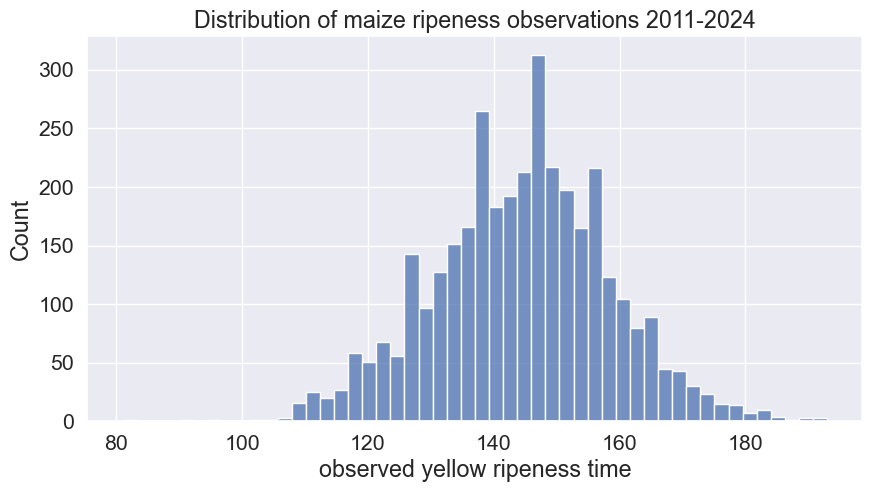

In [107]:
fig, ax = plt.subplots(figsize = (10, 5))
ds['observed yellow ripeness time'] = ds['observed time to yellow ripeness'].dt.days
sns.set(font_scale=1.4)
sns.histplot(data=ds, x="observed yellow ripeness time", bins =50, ax=ax, palette = 'colorblind')
ax.set(ylabel='Count', title='Distribution of maize ripeness observations 2011-2024')
fig.savefig('plots/ripeness_obs_distribution.png', bbox_inches='tight')
#ax.tick_params(axis='both', which='major', labelsize=font_size)#axis='x', 
#ax.tick_params(axis='y', labelsize=10)

In [11]:
tp=3
#0.07, 0.04
#coeff_1 = 0.03
#coeff_2 = 0.025
coeff_1 = 1
coeff_2 = 1
coeff_3 = 1
coeff_1 = 1.008325157733615 
coeff_2 = 0.03658492936480077 
coeff_3 = 0.04598812328016307
#coeff_1 = 0.7867573678269909 
#coeff_2 = 0.037684642877912046 
#coeff_3 = 0.049761431878384825
#coeff_1 = 2.7456293565248133/100#0.5920545713820773/10#
#coeff_2 = 0.03769911854395983 
#coeff_3 = 0.04976143187838482
### changed min temp for maize to 4 just to test (was 8 before)
#resps = [lambda x: coeff_1*modelling_fctns.Wang_Engel_Temp_response(x, 8, 28, 36), lambda x: coeff_1*modelling_fctns.Wang_Engel_Temp_response(x, 8, 28, 36), lambda x: coeff_2*modelling_fctns.Wang_Engel_Temp_response(x, 8, 28, 36), lambda x: coeff_2*modelling_fctns.Wang_Engel_Temp_response(x, 8, 28, 36)]
resps = [lambda x: coeff_1*modelling_fctns.Wang_Engel_Temp_response(x, 2, 28, 36), lambda x: coeff_2*modelling_fctns.Wang_Engel_Temp_response(x, 8, 28, 36), lambda x: coeff_3*modelling_fctns.Wang_Engel_Temp_response(x, 8, 28, 36), lambda x: coeff_3*modelling_fctns.Wang_Engel_Temp_response(x, 8, 28, 36)]
#resps = [lambda x: 0.053*modelling_fctns.Wang_Engel_Temp_response(x, 8, 28, 36), lambda x: 0.053*modelling_fctns.Wang_Engel_Temp_response(x, 8, 28, 36), lambda x: 0.055*modelling_fctns.Wang_Engel_Temp_response(x, 8, 28, 36)]
#[lambda x: 0.0254*modelling_fctns.Wang_Engel_Temp_response(x, 0, 27.5, 40), lambda x: 0.0289*modelling_fctns.Wang_Engel_Temp_response(x, 0, 33, 44)]#0.0254, 0.0289
#thresholds = [0.2, 1, 2]
#thresholds = [0.01, 1.01, 2.01]
thresholds = [1, 2, 3]
Maize_set.dev_under_response(lambda x, y: modelling_fctns.phase_dependent_response(x, y, resps, thresholds), 
                             't2m', thresholds[-1])
Maize_set.get_phase_dates(thresholds)
Maize_set.get_observed_dataset()
Maize_set.get_X_y_for_ML(driver_variable = 't2m', predictor_days = 200, cumulative = False, thinning_parameter = 1, start_year = 2018, end_year = 2024)


Couldn't reset index for station


c:\Users\wlwc1989\Documents\Phenology_Test_Notebooks\phenology_dwd\modelling_fctns.py:16: RuntimeWarning: invalid value encountered in power
  f_T = ( ( (2*(T - T_min)**alpha)*((T_opt - T_min)**alpha) - ((T - T_min)**(2*alpha)) ) / ((T_opt - T_min)**(2*alpha)) )**beta


C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_17600\345150298.py:198: UserWarning: rename 'index' to 'Stations_id' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  self.driver_data_for_ML = self.driver_data_for_ML.rename({'index': 'Stations_id'})


In [20]:
phase_list2 = ['emergence', 'beginning of flowering', 'yellow ripeness']
for index, phase in enumerate(phase_list2):
    print(phase)
    print(str(np.float64(thresholds[index])))
    #Maize_set.phase_dates_array = Maize_set.phase_dates_array.rename(columns={str(np.float64(thresholds[index])):f'modelled time to {phase}'})
    Maize_set.phase_dates_array = Maize_set.phase_dates_array.rename(columns={str(thresholds[index]):f'modelled time to {phase}'})
Maize_set.phase_dates_array['modelled time to beginning of flowering'] = Maize_set.phase_dates_array['modelled time to beginning of flowering'] - Maize_set.phase_dates_array['modelled time to emergence']
Maize_set.phase_dates_array['modelled time to yellow ripeness'] = Maize_set.phase_dates_array['modelled time to yellow ripeness'] - Maize_set.phase_dates_array['modelled time to emergence']
        
Maize_set.get_X_y_for_ML(driver_variable = 't2m', start_year = 2018, end_year = 2024)
Maize_set.driver_frame_for_ML.to_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\Maize_ML_data4.csv')

emergence
1.0
beginning of flowering
2.0
yellow ripeness
3.0


c:\Users\wlwc1989\Documents\Phenology_Test_Notebooks\phenology_dwd\dataset_fctns.py:110: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[104. 104. 103. ... 104. 105. 105.]' has dtype incompatible with timedelta64[ns], please explicitly cast to a compatible dtype first.
  df.loc[:, 'SOS'] = WC_SOS(df['lon'], df['lat'])
C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_25644\2023081155.py:198: UserWarning: rename 'index' to 'Stations_id' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  self.driver_data_for_ML = self.driver_data_for_ML.rename({'index': 'Stations_id'})


In [22]:
Maize_set.phase_dates_calculated = False
Maize_set.get_X_y_for_ML(driver_variable = 't2m', start_year = 2018, end_year = 2024)
Maize_set.driver_frame_for_ML.to_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\Maize_ML_data_t2m.csv')
Maize_set.get_X_y_for_ML(driver_variable = 'd2m', start_year = 2018, end_year = 2024)
Maize_set.driver_frame_for_ML.to_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\Maize_ML_data_d2m.csv')
Maize_set.get_X_y_for_ML(driver_variable = 'ssrd', start_year = 2018, end_year = 2024)
Maize_set.driver_frame_for_ML.to_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\Maize_ML_data_ssrd.csv')
Maize_set.get_X_y_for_ML(driver_variable = 'tp', start_year = 2018, end_year = 2024)
Maize_set.driver_frame_for_ML.to_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\Maize_ML_data_tp.csv')

c:\Users\wlwc1989\Documents\Phenology_Test_Notebooks\phenology_dwd\dataset_fctns.py:110: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[104. 104. 103. ... 104. 105. 105.]' has dtype incompatible with timedelta64[ns], please explicitly cast to a compatible dtype first.
  df.loc[:, 'SOS'] = WC_SOS(df['lon'], df['lat'])
C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_25644\2023081155.py:198: UserWarning: rename 'index' to 'Stations_id' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  self.driver_data_for_ML = self.driver_data_for_ML.rename({'index': 'Stations_id'})
c:\Users\wlwc1989\Documents\Phenology_Test_Notebooks\phenology_dwd\dataset_fctns.py:110: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[104. 104. 103. ... 104. 105. 105.]' has dtype incompatible with timedelta6

In [3]:
address1 = "C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\Saved_files\\PH_Jahresmelder_Landwirtschaft_Kulturpflanze_Mais_akt.txt"
address2 = "C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\Saved_files\\PH_Jahresmelder_Landwirtschaft_Kulturpflanze_Mais_1936_2023_hist.txt"
pd1 = pd.read_csv(address1, encoding = "latin1", engine='python', sep = r';\s+|;\t+|;\s+\t+|;\t+\s+|;|\s+;|\t+;|\s+\t+;|\t+\s+;')
pd2 = pd.read_csv(address2, encoding = "latin1", engine='python', sep = r';\s+|;\t+|;\s+\t+|;\t+\s+|;|\s+;|\t+;|\s+\t+;|\t+\s+;')
pd3 = pd.concat([pd1, pd2], axis = 0)
pd3 = pd3.drop('Unnamed: 9', axis = 1)
pd3.drop_duplicates(inplace=True)
pd3.to_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\Saved_files\\maize_phenology_20250224.csv')
address3 = 'C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\Saved_files\\maize_phenology_20250224.csv'
pd4 = pd.read_csv(address3)

In [84]:
phen_data = Maize_set.phen_data
phen_data = phen_data.where(phen_data['Referenzjahr'] > 2016).dropna(how = 'all')
phen_data['Eintrittsdatum'] = pd.to_datetime(phen_data['Eintrittsdatum'], format = '%Y%m%d')
phen_data['Name of phase'].unique()

array(['beginning of flowering', 'beginning of tilling sowing drilling',
       'beginning of emergence', 'beginning of mil ripeness',
       'beginning of wax-ripe stage', 'yellow ripeness', 'harvest',
       'tip of tassel visible', 'beginning of growth in height'],
      dtype=object)

In [85]:
print(np.isin(phen_data['Name of phase'], ['beginning of emergence', 'beginning of flowering', 'yellow ripeness']).shape,
phen_data.shape)

(34674,) (34674, 13)


In [86]:
cond.shape = phen_data.shape

AttributeError: property 'shape' of 'Series' object has no setter

In [87]:
ripeness_data = phen_data.where(phen_data['Name of phase'] == 'yellow ripeness').dropna()
anthesis_data = phen_data.where(phen_data['Name of phase'] == 'beginning of flowering').dropna()
emergence_data = phen_data.where(phen_data['Name of phase'] == 'beginning of emergence').dropna()
cond = phen_data['Name of phase'].isin(['beginning of emergence', 'beginning of flowering', 'yellow ripeness']) #np.isin(phen_data['Name of phase'], ['beginning of emergence', 'beginning of flowering', 'yellow ripeness']).reshape(phen_data.shape[0])
main_stages_data = phen_data.where(cond).dropna()

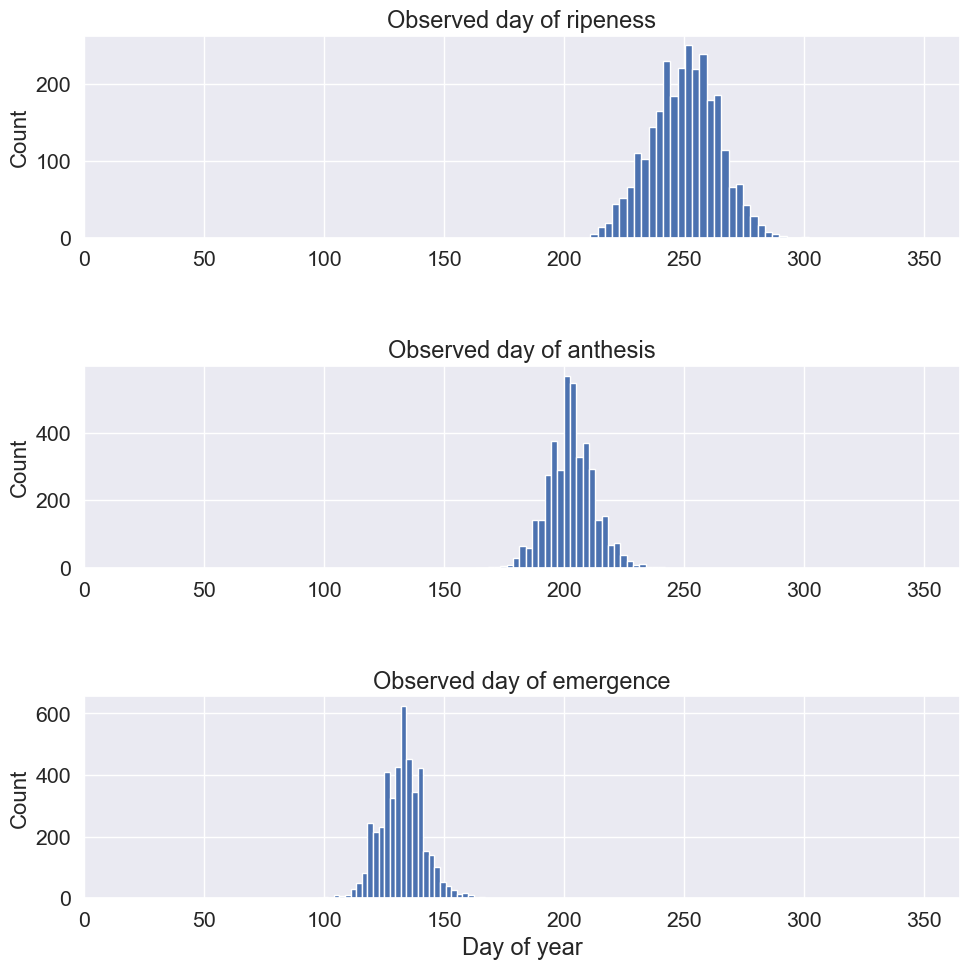

In [88]:
font_size = 17
fig, ax = plt.subplots(3, 1, figsize = (10, 10))

ax[0].hist(ripeness_data['Jultag'], bins = 30)
ax[0].set_xlim([0, 365])
ax[0].set_title('Observed day of ripeness', fontsize = font_size)
#ax[0].set_xlabel('Day of year', fontsize = font_size)
ax[0].set_ylabel('Count', fontsize = font_size - 1)

ax[1].hist(anthesis_data['Jultag'], bins = 30)
ax[1].set_xlim([0, 365])
ax[1].set_title('Observed day of anthesis', fontsize = font_size)
#ax[1].set_xlabel('Day of year', fontsize = font_size)
ax[1].set_ylabel('Count', fontsize = font_size - 1)

ax[2].hist(emergence_data['Jultag'], bins = 30)
ax[2].set_xlim([0, 365])
ax[2].set_title('Observed day of emergence', fontsize = font_size)
ax[2].set_xlabel('Day of year', fontsize = font_size)
ax[2].set_ylabel('Count', fontsize = font_size - 1)

fig.tight_layout(h_pad = 3)
#fig.savefig('plots/avg_num_yearly_obs.png')

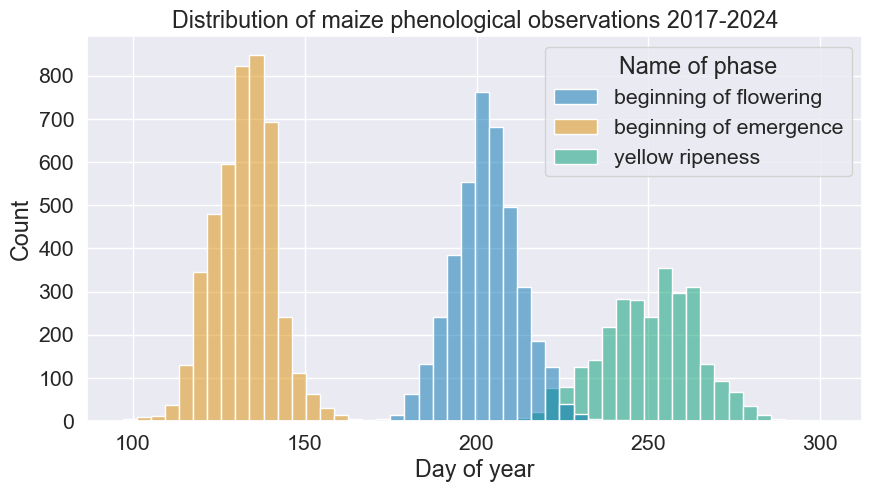

In [89]:
fig, ax = plt.subplots(figsize = (10, 5))
sns.set(font_scale=1.4)
sns.histplot(data=main_stages_data, x="Jultag", hue="Name of phase", bins =50, ax=ax, palette = 'colorblind')
ax.set(xlabel='Day of year', ylabel='Count', title='Distribution of maize phenological observations 2017-2024')
fig.savefig('plots/phenological_obs_distribution.png', bbox_inches='tight')
#ax.tick_params(axis='both', which='major', labelsize=font_size)#axis='x', 
#ax.tick_params(axis='y', labelsize=10)

In [78]:
phase_list2 = ['emergence', 'beginning of flowering', 'yellow ripeness']
thresholds = [0.1, 1, 2]
RMSE_list = []
coord_list = []
Maize_set.get_observed_dataset()
for coeff_1 in np.arange(0.02, 0.09, 0.005):
    for coeff_2 in np.arange(0.02, 0.09, 0.005):
        print([coeff_1, coeff_2])
        resps = [lambda x: coeff_1*modelling_fctns.Wang_Engel_Temp_response(x, 8, 28, 36), lambda x: coeff_1*modelling_fctns.Wang_Engel_Temp_response(x, 8, 28, 36), lambda x: coeff_2*modelling_fctns.Wang_Engel_Temp_response(x, 8, 28, 36)]
        #[lambda x: 0.0254*modelling_fctns.Wang_Engel_Temp_response(x, 0, 27.5, 40), lambda x: 0.0289*modelling_fctns.Wang_Engel_Temp_response(x, 0, 33, 44)]#0.0254, 0.0289
        Maize_set.dev_under_response(lambda x, y: modelling_fctns.phase_dependent_response(x, y, resps, thresholds), 
                                    'tas', thresholds[-1])
        Maize_set.get_phase_dates(thresholds)
        for index, phase in enumerate(phase_list2):
            Maize_set.phase_dates_array = Maize_set.phase_dates_array.rename(columns={str(np.float64(thresholds[index])):f'modelled time to {phase}'})
        Maize_set.phase_dates_array = Maize_set.phase_dates_array.where(Maize_set.phase_dates_array['modelled time to yellow ripeness'] < 200)
        Maize_set.phase_dates_array['modelled time to beginning of flowering'] = Maize_set.phase_dates_array['modelled time to beginning of flowering'] - Maize_set.phase_dates_array['modelled time to emergence']
        Maize_set.phase_dates_array['modelled time to yellow ripeness'] = Maize_set.phase_dates_array['modelled time to yellow ripeness'] - Maize_set.phase_dates_array['modelled time to beginning of flowering']
        ds_comparison = pd.merge(Maize_set.ds_observed, Maize_set.phase_dates_array, how='outer', on=['Referenzjahr', 'Stations_id'])
        ds_comparison = ds_comparison.dropna(subset = ['modelled time to beginning of flowering', 'lat', 'lon'])
        ds_comparison = dataset_fctns.add_SOS_to_df(ds_comparison)
        ds_comparison['observed time to emergence'] = pd.to_datetime(ds_comparison['emergence date']).dt.dayofyear - ds_comparison['SOS']
        RMSE_list.append(RMSE_model2(ds_comparison, phase_list2))
        coord_list.append([coeff_1, coeff_2])



[0.02, 0.02]
Couldn't reset index for station


c:\Users\wlwc1989\Documents\Phenology_Test_Notebooks\phenology_dwd\dataset_fctns.py:107: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[104. 104. 103. ... 105. 105. 105.]' has dtype incompatible with timedelta64[ns], please explicitly cast to a compatible dtype first.
  df.loc[:, 'SOS'] = WC_SOS(df['lon'], df['lat'])
c:\Users\wlwc1989\Documents\Phenology_Test_Notebooks\phenology_dwd\modelling_fctns.py:16: RuntimeWarning: invalid value encountered in power
  f_T = ( ( (2*(T - T_min)**alpha)*((T_opt - T_min)**alpha) - ((T - T_min)**(2*alpha)) ) / ((T_opt - T_min)**(2*alpha)) )**beta


[0.02, 0.025]
Couldn't reset index for station


c:\Users\wlwc1989\Documents\Phenology_Test_Notebooks\phenology_dwd\modelling_fctns.py:16: RuntimeWarning: invalid value encountered in power
  f_T = ( ( (2*(T - T_min)**alpha)*((T_opt - T_min)**alpha) - ((T - T_min)**(2*alpha)) ) / ((T_opt - T_min)**(2*alpha)) )**beta


[0.02, 0.030000000000000002]
Couldn't reset index for station


c:\Users\wlwc1989\Documents\Phenology_Test_Notebooks\phenology_dwd\modelling_fctns.py:16: RuntimeWarning: invalid value encountered in power
  f_T = ( ( (2*(T - T_min)**alpha)*((T_opt - T_min)**alpha) - ((T - T_min)**(2*alpha)) ) / ((T_opt - T_min)**(2*alpha)) )**beta


[0.02, 0.035]
Couldn't reset index for station


c:\Users\wlwc1989\Documents\Phenology_Test_Notebooks\phenology_dwd\modelling_fctns.py:16: RuntimeWarning: invalid value encountered in power
  f_T = ( ( (2*(T - T_min)**alpha)*((T_opt - T_min)**alpha) - ((T - T_min)**(2*alpha)) ) / ((T_opt - T_min)**(2*alpha)) )**beta


[0.02, 0.04000000000000001]
Couldn't reset index for station


c:\Users\wlwc1989\Documents\Phenology_Test_Notebooks\phenology_dwd\modelling_fctns.py:16: RuntimeWarning: invalid value encountered in power
  f_T = ( ( (2*(T - T_min)**alpha)*((T_opt - T_min)**alpha) - ((T - T_min)**(2*alpha)) ) / ((T_opt - T_min)**(2*alpha)) )**beta


[0.02, 0.045000000000000005]
Couldn't reset index for station


c:\Users\wlwc1989\Documents\Phenology_Test_Notebooks\phenology_dwd\modelling_fctns.py:16: RuntimeWarning: invalid value encountered in power
  f_T = ( ( (2*(T - T_min)**alpha)*((T_opt - T_min)**alpha) - ((T - T_min)**(2*alpha)) ) / ((T_opt - T_min)**(2*alpha)) )**beta


KeyboardInterrupt: 

In [ ]:
phase_dates_array
        ds_comparison = pd.merge(Maize_set.ds_observed, Maize_set.phase_dates_array, how='outer', on=['Referenzjahr', 'Stations_id'])
        ds_comparison = ds_comparison.dropna(subset = ['modelled time to beginning of flowering', 'lat', 'lon'])
        ds_comparison = dataset_fctns.add_SOS_to_df(ds_comparison)
        ds_comparison['observed time to emergence'] = pd.to_datetime(ds_comparison['emergence date']).dt.dayofyear - ds_comparison['SOS']
        RMSE_list.append(RMSE_model2(ds_comparison, phase_list2))
        coord_list.append([coeff_1, coeff_2])

In [22]:
print(coord_list[np.linalg.norm(np.array(RMSE_list), axis = 1).argmin()],
      RMSE_list[np.linalg.norm(np.array(RMSE_list), axis = 1).argmin()])

[0.02, 0.02] [nan, nan, nan]


In [23]:
RMSE_list#[np.linalg.norm(np.array(RMSE_list), axis = 1).argmin()]

[[nan, nan, nan],
 [7.220660013771785, 15.393684329665179, 22.578517969171727],
 [8.791872934874018, 16.616525235171434, 29.05142866102073],
 [9.572624255403277, 17.764039123263906, 31.080074235637753],
 [11.187302521381909, 18.282936127019028, 32.09855081285936],
 [12.233118419143224, 18.813491535813228, 34.64408702733335],
 [12.774953394401766, 18.90333754162915, 36.2741655335881],
 [12.883372483542793, 19.395404393982, 37.906292739975285],
 [13.161561185365278, 20.191577529990226, 38.4126778660503],
 [13.817727792842145, 20.463755914358657, 39.08831733042672],
 [14.161385272166976, 20.722957676613575, 39.66489496034962],
 [14.518529049974275, 20.8833810202486, 40.931196772123734],
 [14.745794533374333, 21.128953279011874, 41.75056035094004],
 [15.067820535375198, 21.209035666817805, 42.87106138028109],
 [6.635761699558938, 9.311283477587825, 19.616051429485257],
 [8.180915248410534, 11.43029681999809, 25.134421227368307],
 [10.056459759381381, 12.562090687818632, 27.82148307755934],

In [25]:
ds_comparison#.dropna(subset = ['modelled time to beginning of flowering'])

,Referenzjahr,Stations_id,observed time emergence to beginning of flowering,observed time emergence to yellow ripeness,lat,lon,emergence date,modelled time to emergence,modelled time to beginning of flowering,modelled time to yellow ripeness
0,1951.0,7617.0,29.0,NaN,54.6167,9.0333,NaT,NaN,NaN,NaN
1,1951.0,7899.0,80.0,NaN,52.0833,9.5667,NaT,NaN,NaN,NaN
2,1951.0,8137.0,50.0,NaN,52.8667,9.6000,NaT,NaN,NaN,NaN
3,1951.0,8191.0,54.0,NaN,53.2667,10.1167,NaT,NaN,NaN,NaN
4,1951.0,8234.0,98.0,NaN,52.9333,11.1167,NaT,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
28902,2023.0,19612.0,84.0,121.0,52.0507,10.6362,2023-05-18,38.0,76.0,114.0
28903,2023.0,19700.0,78.0,132.0,50.4316,11.9443,2023-05-19,49.0,85.0,128.0
28904,2023.0,19722.0,55.0,109.0,47.8655,9.0147,2023-05-21,38.0,71.0,107.0
28905,2023.0,19770.0,NaN,NaN,NaN,NaN,2023-05-20,36.0,74.0,113.0


In [24]:
dataset_fctns.add_SOS_to_df(ds_comparison.dropna(subset = ['modelled time to beginning of flowering', 'lat', 'lon']))

c:\Users\wlwc1989\Documents\Phenology_Test_Notebooks\phenology_dwd\dataset_fctns.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SOS'] = WC_SOS(df['lon'], df['lat'])


,Referenzjahr,Stations_id,observed time emergence to beginning of flowering,observed time emergence to yellow ripeness,lat,lon,emergence date,modelled time to emergence,modelled time to beginning of flowering,modelled time to yellow ripeness,SOS
24456,2017.0,7532.0,80.0,134.0,54.4000,8.7667,2017-05-14,45.0,98.0,162.0,103.0
24457,2017.0,7564.0,80.0,128.0,54.7167,9.9500,2017-05-10,44.0,101.0,183.0,104.0
24458,2017.0,7564.0,80.0,128.0,54.7167,9.9500,2017-05-10,35.0,81.0,113.0,104.0
24459,2017.0,7592.0,76.0,NaN,53.4833,10.6333,2017-05-19,40.0,84.0,135.0,104.0
24461,2017.0,7616.0,76.0,139.0,54.6167,8.9667,2017-05-14,46.0,103.0,187.0,103.0
...,...,...,...,...,...,...,...,...,...,...,...
28900,2023.0,19587.0,49.0,123.0,48.7091,9.2147,2023-05-27,36.0,67.0,94.0,106.0
28902,2023.0,19612.0,84.0,121.0,52.0507,10.6362,2023-05-18,38.0,76.0,114.0,105.0
28903,2023.0,19700.0,78.0,132.0,50.4316,11.9443,2023-05-19,49.0,85.0,128.0,107.0
28904,2023.0,19722.0,55.0,109.0,47.8655,9.0147,2023-05-21,38.0,71.0,107.0,109.0


In [55]:
Maize_set.phase_dates_array

,1,2,3,Referenzjahr,Stations_id
0,26.0,29.0,115.0,2022,7521.0
1,24.0,26.0,108.0,2023,7521.0
2,26.0,28.0,114.0,2022,7532.0
3,18.0,26.0,88.0,2023,7532.0
4,23.0,26.0,65.0,2022,7592.0
...,...,...,...,...,...
4443,6.0,9.0,104.0,2019,19727.0
4444,20.0,22.0,77.0,2017,19731.0
4445,26.0,28.0,64.0,2017,19914.0
4446,3.0,4.0,23.0,2018,19914.0


In [138]:
ds = Maize_set.driver_frame_for_ML['modelled time to emergence'] + pd.to_datetime(Maize_set.driver_frame_for_ML['WC SOS']).dt.dayofyear
ds = ds.where(ds < 200)
plt.hist(ds.dropna(), bins = 20)

KeyError: 'modelled time to emergence'

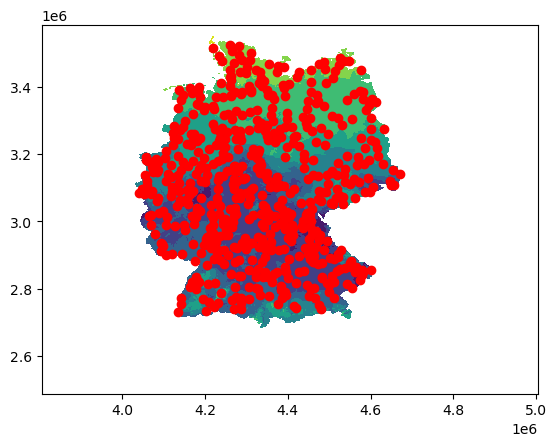

In [11]:
fig, axs = plt.subplots()
axs.contourf(Maize_set.T_mean['x'], Maize_set.T_mean['y'], Maize_set.T_mean['tas'].isel(time = 0).values)
for index, x in enumerate(Maize_set.x_epsg):
    axs.plot(x, Maize_set.y_epsg[index], 'ro')

In [104]:
## Functions for ML ##    
def put_obs_data_in_input_array(self): #, predictor_days = 200
    y_data = {}
    for phase_time in self.ds_observed.columns:
        if phase_time != 'lat' and phase_time != 'lon':
            y_data[phase_time] = (['modelpoint'], self.ds_observed[phase_time].values)
    #print(y_data)
    obs_data = xr.Dataset(data_vars = y_data,
                            coords = {'Referenzjahr':(['modelpoint'], np.int64(self.ds_observed.index.get_level_values(0))),
                                    'Stations_id':(['modelpoint'], np.int64(self.ds_observed.index.get_level_values(1)))}
                                    )
    #print(obs_data)
    obs_data = obs_data.set_xindex(['Referenzjahr', 'Stations_id'])
    self.GDD_driver_data = self.GDD_driver_data.reset_index('modelpoint')
    #self.GDD_driver_data['Stations_id'] = self.GDD_driver_data['Stations_id'].astype(np.int64)
    #self.GDD_driver_data['Referenzjahr'] = self.GDD_driver_data['Referenzjahr'].astype(np.int64)
    self.GDD_driver_data = self.GDD_driver_data.set_coords(['Referenzjahr', 'Stations_id']) #self.data_for_ML = self.data_for_ML.set_coords(['Referenzjahr', 'Stations_id'])
    self.GDD_driver_data = self.GDD_driver_data.set_xindex(['Referenzjahr', 'Stations_id']) #self.data_for_ML = self.data_for_ML.set_xindex(['Referenzjahr', 'Stations_id'])
    self.GDD_driver_data = xr.merge([self.GDD_driver_data, obs_data], join='left') #self.data_for_ML = xr.merge([self.data_for_ML, obs_data], join='left')#[driver_variable]
    self.GDD_driver_data = self.GDD_driver_data.dropna('modelpoint') #self.data_for_ML = self.data_for_ML.dropna('modelpoint')


In [89]:
def get_X_y_for_ML(self, driver_variable = 'tas', predictor_days = 200, cumulative = False, thinning_parameter = 1, start_year = 2020, end_year = 2023):
    self.just_emergence = dataset_fctns.add_EOS_to_df(self.just_emergence)
    self.just_emergence = dataset_fctns.add_SOS_to_df(self.just_emergence)
    self.just_emergence['WC SOS date'] = pd.to_datetime(self.just_emergence['Referenzjahr'], format='%Y') + pd.to_timedelta(self.just_emergence['SOS'], 'D')
    self.just_emergence['SOS'] = pd.to_timedelta(self.just_emergence['SOS'], 'D')
    time_station = xr.Dataset.from_dataframe(self.just_emergence[['Stations_id', 'SOS']].drop_duplicates()) #, 'Referenzjahr'
    time_station = time_station.set_coords('Stations_id').set_xindex(['Stations_id'])
    time_station = time_station.drop_vars('index')
    time_station = time_station.expand_dims(dim={'time':pd.to_timedelta(np.arange(0, predictor_days), 'D')})
    time_station = time_station.expand_dims(dim={'Referenzjahr':pd.date_range(f'{start_year}-01-01', periods = end_year - start_year, freq='YS')})
    time_station['SOS'] = time_station['SOS'] + time_station['Referenzjahr'] + time_station['time'] + pd.Timedelta(12, 'h')
    time_station = time_station.rename({'time':'time_from_SOS', 'SOS':'time'})
    time_station = time_station.reset_index('Stations_id').reset_coords(names = 'Stations_id')
    self.time_station = time_station
    self.driver_data_for_ML = self.GDD_driver_data[driver_variable].sel(time_station)
    self.driver_data_for_ML = self.driver_data_for_ML.rename({'index': 'Stations_id'})
    self.driver_data_for_ML = self.driver_data_for_ML.set_xindex(['Stations_id'])
    self.driver_data_for_ML['Referenzjahr'] = pd.to_datetime(self.driver_data_for_ML['Referenzjahr']).year
    self.driver_frame_for_ML = self.driver_data_for_ML.to_dataframe(dim_order = ['Referenzjahr', 'Stations_id', 'time_from_SOS'])
    self.driver_frame_for_ML = pd.concat([self.driver_frame_for_ML['tas'].unstack(),
                                          self.driver_frame_for_ML['lat'].unstack()['0 days'].rename('lat'),
                                          self.driver_frame_for_ML['lon'].unstack()['0 days'].rename('lon'),
                                          self.driver_frame_for_ML['time'].unstack()['0 days'].rename('WC SOS')], axis=1)
    self.driver_frame_for_ML.rename(columns={self.driver_frame_for_ML.columns[x]: f'{driver_variable} day {x}' for x in range(200)}, inplace=True)
    self.driver_frame_for_ML = pd.merge(hmm.driver_frame_for_ML.reset_index(), hmm.ds_observed, how='left', on=['Referenzjahr', 'Stations_id'], suffixes=(None, '_observed')).drop(['lat_observed', 'lon_observed'], axis = 1)
    #self.X_for_ML = self.driver_data_for_ML[:predictor_days, :].values.T
    #if cumulative:
    #    self.X_for_ML = np.cumsum(self.X_for_ML, axis=1)
    #if thinning_parameter != 1:
    #    self.X_for_ML = self.X_for_ML[:, ::thinning_parameter]
    #self.y_for_ML = np.array([self.GDD_driver_data[phase_time].values for phase_time in self.ds_observed.columns[:-2]])[:predictor_days, :].T
    #for station in self.just_emergence['Stations_id'].unique():
    #    just_station = self.just_emergence.where(self.just_emergence['Stations_id'] == station).dropna()
    #    for year in just_station['Referenzjahr'].unique():
    #        just_station_year = just_station.where(just_station['Referenzjahr'] == year).dropna()
    #        print(just_station_year)
    #        station_data = self.GDD_driver_data.sel({'Stations_id':station})
    #        #, time = slice(just_station_year['WC SOS date'].values[0] + pd.Timedelta(12, 'h'), just_station_year['WC SOS date'].values[0] + pd.Timedelta(12, 'h') + pd.Timedelta(predictor_days, 'D')))
    #        print(station_data)
    return self

In [ ]:
hmm = get_X_y_for_ML(Maize_set, start_year = 2022, end_year=2025)

In [ ]:
pd.merge(hmm.driver_frame_for_ML.reset_index(), hmm.ds_observed, how='left', on=['Referenzjahr', 'Stations_id'], suffixes=(None, '_observed')).drop(['lat_observed', 'lon_observed'], axis = 1)

In [ ]:
pd.concat([hmm.driver_frame_for_ML, hmm.ds_observed.set_index(['Referenzjahr', 'Stations_id'])], axis=1, )
hmm.driver_frame_for_ML.join(hmm.ds_observed.set_index(['Referenzjahr', 'Stations_id']), how='left')

In [ ]:
hmm.driver_frame_for_ML.index.get_level_values(0) = hmm.driver_frame_for_ML.index.get_level_values(0).year#['Referenzjahr']

In [73]:
obs = xr.Dataset.from_dataframe(hmm.ds_observed)
obs = obs.reset_index('index')
obs = obs.assign_coords({'Stations_id':obs['Stations_id'],'Referenzjahr':obs['Referenzjahr']})
obs = obs.set_xindex(['Stations_id', 'Referenzjahr'])

In [5]:
Maize_set.dev_under_response(lambda x, y: modelling_fctns.phase_dependent_response(x, y, resps, thresholds), 
                             'tas', thresholds[-1])
Maize_set.get_phase_dates(thresholds)


<xarray.Dataset> Size: 14kB
Dimensions:                (Emergence observation: 600)
Coordinates:
  * Emergence observation  (Emergence observation) int64 5kB 448 983 ... 411726
Data variables:
    Stations_id            (Emergence observation) float64 5kB 7.521e+03 ... ...
    time                   (Emergence observation) datetime64[ns] 5kB 2022-05...


C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_7620\3188619908.py:113: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  t_dev = np.zeros(time_station.dims['Emergence observation']) #Continuous development time. When this passes through some thresholds then have change in phase.


ValueError: those coordinates already have an index: {'Stations_id'}

In [ ]:
Maize_set.compare_modelled_observed()

In [36]:
observed_dataset.to_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\observed_times.csv')

In [2]:
Maize_set = Phenology_set("C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\Saved_files\\PH_Jahresmelder_Landwirtschaft_Kulturpflanze_Mais_1936_2023_hist.txt")
Maize_set.drop_columns(['Unnamed: 9'])
Maize_set.phase_order_name([10, 12, 67, 65, 5, 6, 19, 20, 21, 24, ])
Maize_set.get_mean_T('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\Saved_files\\tas_hyras_5_1951_2020_v5-0_de.nc')
Maize_set.make_input_array()
tp=3
resps = [lambda x: 0.053*modelling_fctns.Wang_Engel_Temp_response(x, 8, 28, 36), lambda x: 0.055*modelling_fctns.Wang_Engel_Temp_response(x, 8, 28, 36)]
#[lambda x: 0.0254*modelling_fctns.Wang_Engel_Temp_response(x, 0, 27.5, 40), lambda x: 0.0289*modelling_fctns.Wang_Engel_Temp_response(x, 0, 33, 44)]#0.0254, 0.0289
thresholds = [1, 2]
Maize_set.dev_under_response(lambda x, y: modelling_fctns.phase_dependent_response(x, y, resps, thresholds), 
                             'tas', thresholds[-1])
Maize_set.get_phase_dates(thresholds)
Maize_set.phase_list = ['beginning of flowering', 'yellow ripeness']
Maize_set.get_observed_dataset()#['beginning of emergence', 'beginning of flowering', 'beginning of mil ripeness'])#
Maize_set.get_modelled_dataset()#['beginning of emergence', 'beginning of flowering', 'beginning of mil ripeness'])#
Maize_set.put_obs_data_in_input_array()
Maize_set.compare_modelled_observed()
Maize_set.get_X_y_for_ML('tas', cumulative=True, thinning_parameter=tp)
Maize_set.subsample_X_y(subsample_frac=0.8)
Maize_set.decision_tree(md=3)#['beginning of emergence', 'beginning of flowering', 'beginning of mil ripeness'])#
Maize_set.ML_modelled_observed()

In [16]:
# data rows of csv file
coords = Maize_set.phen_data[['lat', 'lon', 'Stations_id']].drop_duplicates().values
# using the savetxt
# from the numpy module
np.savetxt("C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\Saved_files\\station_coords.csv",
        coords,
        delimiter =", ",
        fmt ='% s')

In [12]:
phase_list = ['beginning of flowering', 'yellow ripeness']
training_means = []
for phase in phase_list:
    training_means.append(Maize_set.ds_ML_modelled_observed.where(Maize_set.ds_ML_modelled_observed['Training'] ==True)[f'observed time emergence to {phase}'].mean())
    print(Maize_set.ds_ML_modelled_observed.where(Maize_set.ds_ML_modelled_observed['Training'] ==True)[f'observed time emergence to {phase}'].count())
RMSE_ML_model(Maize_set.ds_ML_modelled_observed.where(Maize_set.ds_ML_modelled_observed['Training'] ==False), phase_list, training_means)
#plot_error_distn(Maize_set.ds_ML_modelled_observed.where(Maize_set.ds_ML_modelled_observed['Training'] ==False), phase_list, training_means)

9872
9872
Phase: beginning of flowering
RMSE for ML is 10.2
RMSE for model is 14.2
RMSE to training mean is 10.2
Phase: yellow ripeness
RMSE for ML is 15.3
RMSE for model is 27.5
RMSE to training mean is 13.7


In [ ]:
phase_list = ['beginning of emergence', 'beginning of flowering', 'beginning of mil ripeness']#['beginning of emergence', 'beginning of flowering', 'beginning of mil ripeness', 'harvest']
#Maize_set.get_observed_dataset(phase_list=phase_list)
plotting.plot_obs_per_year(Maize_set.ds_observed, 'obs_per_year', phase_list=phase_list)
plotting.hist2d_locations(Maize_set.ds_observed.loc[2020].dropna()['lat'], Maize_set.ds_observed.loc[2020].dropna()['lon'], bin_num=5)
plotting.box_plot_modelled_observed(Maize_set.ds_ML_modelled_observed.where(Maize_set.ds_ML_modelled_observed['Training'] ==False), ['beginning of flowering', 'yellow ripeness'])

In [ ]:
tree_rules = tree.export_text(Maize_set.regr, feature_names=[f'Day {tp*i} cum. temp' for i in range(np.int64(np.floor(200/tp)))])
print(Maize_set.y_for_ML)
print(tree_rules)